# Setup 
(90% copy paste from https://colab.research.google.com/drive/1u8larhpxy8w4mMsJiSBddNOzFGj7_RTn?usp=sharing)

## Dependencies

In [ ]:
!py -V

In [ ]:
!pip install transformer_lens
!pip install gradio
!pip install seaborn

In [1]:
from IPython import get_ipython # type: ignore
ipython = get_ipython(); assert ipython is not None
ipython.run_line_magic("load_ext", "autoreload")
ipython.run_line_magic("autoreload", "2")
import transformer_lens
import graph_code
from transformer_lens import HookedTransformer, utils
import torch
import seaborn as sns 
import numpy as np
import gradio as gr
import pprint
import json
import torch.nn as nn
import torch.nn.functional as F
from datasets import load_dataset
from huggingface_hub import HfApi
from IPython.display import HTML
from functools import partial
import tqdm.notebook as tqdm
import plotly.express as px
import pandas as pd
import pickle
import einops
from jaxtyping import Float, Int
from typing import Optional, Callable, Union, List, Tuple
from torch import Tensor
import networkx as nx
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import dill as pickle

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Defining the Autoencoder

In [3]:
cfg = {
    "seed": 49,
    "batch_size": 4096,
    "buffer_mult": 384,
    "lr": 1e-4,
    "num_tokens": int(2e9),
    "l1_coeff": 3e-4,
    "beta1": 0.9,
    "beta2": 0.99,
    "dict_mult": 8,
    "seq_len": 128,
    "d_mlp": 2048,
    "enc_dtype":"fp32",
    "remove_rare_dir": False,
}
cfg["model_batch_size"] = 64
cfg["buffer_size"] = cfg["batch_size"] * cfg["buffer_mult"]
cfg["buffer_batches"] = cfg["buffer_size"] // cfg["seq_len"]

DTYPES = {"fp32": torch.float32, "fp16": torch.float16, "bf16": torch.bfloat16}
class AutoEncoder(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        d_hidden = cfg["d_mlp"] * cfg["dict_mult"]
        d_mlp = cfg["d_mlp"]
        l1_coeff = cfg["l1_coeff"]
        dtype = DTYPES[cfg["enc_dtype"]]
        torch.manual_seed(cfg["seed"])
        self.W_enc = nn.Parameter(torch.nn.init.kaiming_uniform_(torch.empty(d_mlp, d_hidden, dtype=dtype)))
        self.W_dec = nn.Parameter(torch.nn.init.kaiming_uniform_(torch.empty(d_hidden, d_mlp, dtype=dtype)))
        self.b_enc = nn.Parameter(torch.zeros(d_hidden, dtype=dtype))
        self.b_dec = nn.Parameter(torch.zeros(d_mlp, dtype=dtype))

        self.W_dec.data[:] = self.W_dec / self.W_dec.norm(dim=-1, keepdim=True)

        self.d_hidden = d_hidden
        self.l1_coeff = l1_coeff

        self.to(device)

    def forward(self, x):
        x_cent = x - self.b_dec
        acts = F.relu(x_cent @ self.W_enc + self.b_enc)
        x_reconstruct = acts @ self.W_dec + self.b_dec
        l2_loss = (x_reconstruct.float() - x.float()).pow(2).sum(-1).mean(0)
        l1_loss = self.l1_coeff * (acts.float().abs().sum())
        loss = l2_loss + l1_loss
        return loss, x_reconstruct, acts, l2_loss, l1_loss

    @torch.no_grad()
    def remove_parallel_component_of_grads(self):
        W_dec_normed = self.W_dec / self.W_dec.norm(dim=-1, keepdim=True)
        W_dec_grad_proj = (self.W_dec.grad * W_dec_normed).sum(-1, keepdim=True) * W_dec_normed
        self.W_dec.grad -= W_dec_grad_proj

    # def get_version(self):
    #     return 1+max([int(file.name.split(".")[0]) for file in list(SAVE_DIR.iterdir()) if "pt" in str(file)])

    # def save(self):
    #     version = self.get_version()
    #     torch.save(self.state_dict(), SAVE_DIR/(str(version)+".pt"))
    #     with open(SAVE_DIR/(str(version)+"_cfg.json"), "w") as f:
    #         json.dump(cfg, f)
    #     print("Saved as version", version)

    # def load(cls, version):
    #     cfg = (json.load(open(SAVE_DIR/(str(version)+"_cfg.json"), "r")))
    #     pprint.pprint(cfg)
    #     self = cls(cfg=cfg)
    #     self.load_state_dict(torch.load(SAVE_DIR/(str(version)+".pt")))
    #     return self

    @classmethod
    def load_from_hf(cls, version):
        """
        Loads the saved autoencoder from HuggingFace.

        Version is expected to be an int, or "run1" or "run2"

        version 25 is the final checkpoint of the first autoencoder run,
        version 47 is the final checkpoint of the second autoencoder run.
        """
        if version=="run1":
            version = 25
        elif version=="run2":
            version = 47

        cfg = utils.download_file_from_hf("NeelNanda/sparse_autoencoder", f"{version}_cfg.json")
        pprint.pprint(cfg)
        self = cls(cfg=cfg)
        self.load_state_dict(utils.download_file_from_hf("NeelNanda/sparse_autoencoder", f"{version}.pt", force_is_torch=True))
        return self

## Utils

### Get Reconstruction Loss

In [4]:
def replacement_hook(mlp_post, hook, encoder):
    mlp_post_reconstr = encoder(mlp_post)[1]
    return mlp_post_reconstr

def mean_ablate_hook(mlp_post, hook):
    mlp_post[:] = mlp_post.mean([0, 1])
    return mlp_post

def zero_ablate_hook(mlp_post, hook):
    mlp_post[:] = 0.
    return mlp_post

@torch.no_grad()
def get_recons_loss(num_batches=5, local_encoder=None):
    if local_encoder is None:
        local_encoder = encoder
    loss_list = []
    for i in range(num_batches):
        tokens = all_tokens[torch.randperm(len(all_tokens))[:cfg["model_batch_size"]]]
        loss = model(tokens, return_type="loss")
        recons_loss = model.run_with_hooks(tokens, return_type="loss", fwd_hooks=[(utils.get_act_name("post", 0), partial(replacement_hook, encoder=local_encoder))])
        # mean_abl_loss = model.run_with_hooks(tokens, return_type="loss", fwd_hooks=[(utils.get_act_name("post", 0), mean_ablate_hook)])
        zero_abl_loss = model.run_with_hooks(tokens, return_type="loss", fwd_hooks=[(utils.get_act_name("post", 0), zero_ablate_hook)])
        loss_list.append((loss, recons_loss, zero_abl_loss))
    losses = torch.tensor(loss_list)
    loss, recons_loss, zero_abl_loss = losses.mean(0).tolist()

    print(f"loss: {loss:.4f}, recons_loss: {recons_loss:.4f}, zero_abl_loss: {zero_abl_loss:.4f}")
    score = ((zero_abl_loss - recons_loss)/(zero_abl_loss - loss))
    print(f"Reconstruction Score: {score:.2%}")
    # print(f"{((zero_abl_loss - mean_abl_loss)/(zero_abl_loss - loss)).item():.2%}")
    return score, loss, recons_loss, zero_abl_loss

### Get Frequencies

In [5]:
# Frequency
@torch.no_grad()
def get_freqs(num_batches=25, local_encoder=None, batch_size=None):
    if local_encoder is None:
        local_encoder = encoder
    act_freq_scores = torch.zeros(local_encoder.d_hidden, dtype=torch.float32).to(device)
    total = 0
    if batch_size is None:
        batch_size = cfg["model_batch_size"]
    for i in tqdm.trange(num_batches):
        tokens = all_tokens[torch.randperm(len(all_tokens))[:batch_size]]

        _, cache = model.run_with_cache(tokens, stop_at_layer=1, names_filter=utils.get_act_name("post", 0))
        mlp_acts = cache[utils.get_act_name("post", 0)]
        mlp_acts = mlp_acts.reshape(-1, d_mlp)

        hidden = local_encoder(mlp_acts)[2]

        act_freq_scores += (hidden > 0).sum(0)
        total+=hidden.shape[0]
    act_freq_scores /= total
    num_dead = (act_freq_scores==0).float().mean()
    print("Num dead", num_dead)
    return act_freq_scores

## Visualise Feature Utils

In [6]:
from html import escape
import colorsys

from IPython.display import display

SPACE = "·"
NEWLINE="↩"
TAB = "→"

def create_html(strings, values, max_value=None, saturation=0.5, allow_different_length=False, return_string=False):
    # escape strings to deal with tabs, newlines, etc.
    escaped_strings = [escape(s, quote=True) for s in strings]
    processed_strings = [
        s.replace("\n", f"{NEWLINE}<br/>").replace("\t", f"{TAB}&emsp;").replace(" ", "&nbsp;")
        for s in escaped_strings
    ]

    if isinstance(values, torch.Tensor) and len(values.shape)>1:
        values = values.flatten().tolist()

    if not allow_different_length:
        assert len(processed_strings) == len(values)

    # scale values
    if max_value is None:
        max_value = max(max(values), -min(values))+1e-3
    scaled_values = [v / max_value * saturation for v in values]

    # create html
    html = ""
    for i, s in enumerate(processed_strings):
        if i<len(scaled_values):
            v = scaled_values[i]
        else:
            v = 0
        if v < 0:
            hue = 0  # hue for red in HSV
        else:
            hue = 0.66  # hue for blue in HSV
        rgb_color = colorsys.hsv_to_rgb(
            hue, v, 1
        )  # hsv color with hue 0.66 (blue), saturation as v, value 1
        hex_color = "#%02x%02x%02x" % (
            int(rgb_color[0] * 255),
            int(rgb_color[1] * 255),
            int(rgb_color[2] * 255),
        )
        html += f'<span style="background-color: {hex_color}; border: 1px solid lightgray; font-size: 16px; border-radius: 3px;">{s}</span>'
    if return_string:
        return html
    else:
        display(HTML(html))

def basic_feature_vis(text, feature_index, max_val=0):
    feature_in = encoder.W_enc[:, feature_index]
    feature_bias = encoder.b_enc[feature_index]
    _, cache = model.run_with_cache(text, stop_at_layer=1, names_filter=utils.get_act_name("post", 0))
    mlp_acts = cache[utils.get_act_name("post", 0)][0]
    feature_acts = F.relu((mlp_acts - encoder.b_dec) @ feature_in + feature_bias)
    if max_val==0:
        max_val = max(1e-7, feature_acts.max().item())
        # print(max_val)
    # if min_val==0:
    #     min_val = min(-1e-7, feature_acts.min().item())
    return basic_token_vis_make_str(text, feature_acts, max_val)
def basic_token_vis_make_str(strings, values, max_val=None):
    if not isinstance(strings, list):
        strings = model.to_str_tokens(strings)
    values = utils.to_numpy(values)
    if max_val is None:
        max_val = values.max()
    # if min_val is None:
    #     min_val = values.min()
    header_string = f"<h4>Max Range <b>{values.max():.4f}</b> Min Range: <b>{values.min():.4f}</b></h4>"
    header_string += f"<h4>Set Max Range <b>{max_val:.4f}</b></h4>"
    # values[values>0] = values[values>0]/ma|x_val
    # values[values<0] = values[values<0]/abs(min_val)
    body_string = create_html(strings, values, max_value=max_val, return_string=True)
    return header_string + body_string
# display(HTML(basic_token_vis_make_str(tokens[0, :10], mlp_acts[0, :10, 7], 0.1)))
# # %%
# The `with gr.Blocks() as demo:` syntax just creates a variable called demo containing all these components
import gradio as gr
try:
    demos[0].close()
except:
    pass
demos = [None]
def make_feature_vis_gradio(feature_id, starting_text=None, batch=None, pos=None):
    if starting_text is None:
        starting_text = model.to_string(all_tokens[batch, 1:pos+1])
    try:
        demos[0].close()
    except:
        pass
    with gr.Blocks() as demo:
        gr.HTML(value=f"Hacky Interactive Neuroscope for gelu-1l")
        # The input elements
        with gr.Row():
            with gr.Column():
                text = gr.Textbox(label="Text", value=starting_text)
                # Precision=0 makes it an int, otherwise it's a float
                # Value sets the initial default value
                feature_index = gr.Number(
                    label="Feature Index", value=feature_id, precision=0
                )
                # # If empty, these two map to None
                max_val = gr.Number(label="Max Value", value=None)
                # min_val = gr.Number(label="Min Value", value=None)
                inputs = [text, feature_index, max_val]
        with gr.Row():
            with gr.Column():
                # The output element
                out = gr.HTML(label="Neuron Acts", value=basic_feature_vis(starting_text, feature_id))
        for inp in inputs:
            inp.change(basic_feature_vis, inputs, out)
    demo.launch(share=True)
    demos[0] = demo

### Inspecting Top Logits

In [7]:
SPACE = "·"
NEWLINE="↩"
TAB = "→"
def process_token(s):
    if isinstance(s, torch.Tensor):
        s = s.item()
    if isinstance(s, np.int64):
        s = s.item()
    if isinstance(s, int):
        s = model.to_string(s)
    s = s.replace(" ", SPACE)
    s = s.replace("\n", NEWLINE+"\n")
    s = s.replace("\t", TAB)
    return s

def process_tokens(l):
    if isinstance(l, str):
        l = model.to_str_tokens(l)
    elif isinstance(l, torch.Tensor) and len(l.shape)>1:
        l = l.squeeze(0)
    return [process_token(s) for s in l]

def process_tokens_index(l):
    if isinstance(l, str):
        l = model.to_str_tokens(l)
    elif isinstance(l, torch.Tensor) and len(l.shape)>1:
        l = l.squeeze(0)
    return [f"{process_token(s)}/{i}" for i,s in enumerate(l)]

def create_vocab_df(logit_vec, make_probs=False, full_vocab=None):
    if full_vocab is None:
        full_vocab = process_tokens(model.to_str_tokens(torch.arange(model.cfg.d_vocab)))
    vocab_df = pd.DataFrame({"token": full_vocab, "logit": utils.to_numpy(logit_vec)})
    if make_probs:
        vocab_df["log_prob"] = utils.to_numpy(logit_vec.log_softmax(dim=-1))
        vocab_df["prob"] = utils.to_numpy(logit_vec.softmax(dim=-1))
    return vocab_df.sort_values("logit", ascending=False)

### Make Token DataFrame

In [8]:
def list_flatten(nested_list):
    return [x for y in nested_list for x in y]
def make_token_df(tokens, len_prefix=5, len_suffix=1):
    str_tokens = [process_tokens(model.to_str_tokens(t)) for t in tokens]
    unique_token = [[f"{s}/{i}" for i, s in enumerate(str_tok)] for str_tok in str_tokens]

    context = []
    batch = []
    pos = []
    label = []
    for b in range(tokens.shape[0]):
        # context.append([])
        # batch.append([])
        # pos.append([])
        # label.append([])
        for p in range(tokens.shape[1]):
            prefix = "".join(str_tokens[b][max(0, p-len_prefix):p])
            if p==tokens.shape[1]-1:
                suffix = ""
            else:
                suffix = "".join(str_tokens[b][p+1:min(tokens.shape[1]-1, p+1+len_suffix)])
            current = str_tokens[b][p]
            context.append(f"{prefix}|{current}|{suffix}")
            batch.append(b)
            pos.append(p)
            label.append(f"{b}/{p}")
    # print(len(batch), len(pos), len(context), len(label))
    return pd.DataFrame(dict(
        str_tokens=list_flatten(str_tokens),
        unique_token=list_flatten(unique_token),
        context=context,
        batch=batch,
        pos=pos,
        label=label,
    ))

## Loading the Model

In [9]:
model = HookedTransformer.from_pretrained("gelu-1l").to(DTYPES[cfg["enc_dtype"]])
n_layers = model.cfg.n_layers
d_model = model.cfg.d_model
n_heads = model.cfg.n_heads
d_head = model.cfg.d_head
d_mlp = model.cfg.d_mlp
d_vocab = model.cfg.d_vocab

d:\AK_Q3_2024\MATS\mats_env\Lib\site-packages\transformer_lens\utils.py:62: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(file_path, map_location="cpu")
d:

Loaded pretrained model gelu-1l into HookedTransformer
Changing model dtype to torch.float32


## Loading Data

In [10]:
data = load_dataset("NeelNanda/c4-code-20k", split="train")
tokenized_data = utils.tokenize_and_concatenate(data, model.tokenizer, max_length=128)
tokenized_data = tokenized_data.shuffle(42)
all_tokens = tokenized_data["tokens"]

# Analysis

## Loading the Autoencoder and Checking reconstruction loss

There are two runs on separate random seeds, along with a bunch of intermediate checkpoints

In [11]:
auto_encoder_run = "run1" # @param ["run1", "run2"]
encoder = AutoEncoder.load_from_hf(auto_encoder_run)

{'batch_size': 4096,
 'beta1': 0.9,
 'beta2': 0.99,
 'buffer_batches': 12288,
 'buffer_mult': 384,
 'buffer_size': 1572864,
 'd_mlp': 2048,
 'dict_mult': 8,
 'enc_dtype': 'fp32',
 'l1_coeff': 0.0003,
 'lr': 0.0001,
 'model_batch_size': 512,
 'num_tokens': 2000000000,
 'seed': 52,
 'seq_len': 128}


d:\AK_Q3_2024\MATS\mats_env\Lib\site-packages\transformer_lens\utils.py:62: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(file_path, map_location="cpu")


We run the model and replace the MLP activations with those reconstructed from the autoencoder, and get 91% loss recovered

In [12]:
_ = get_recons_loss(num_batches=5, local_encoder=encoder)

loss: 3.2546, recons_loss: 3.7507, zero_abl_loss: 8.8403
Reconstruction Score: 91.12%


## Feature statistics

In [213]:
freqs_11b = get_freqs(num_batches = 11, local_encoder = encoder)

  0%|          | 0/11 [00:00<?, ?it/s]

Num dead tensor(0.0015)


In [17]:
freqs = get_freqs(num_batches = 50, local_encoder = encoder)

  0%|          | 0/50 [00:00<?, ?it/s]

Num dead tensor(0.)


## Manual feature exploration

In [13]:
prompts = {}
prompt_tokens = {}
prompts['bio'] = ["This drug has unique characteristics, and nowadays it does not have analogues. It contains Isotretinoin, a structural analogue of vitamin A. As it has analogical structure to vitamin A, the therapeutic characteristics are similar.",
                "Reconstructive surgery is performed on abnormal structures of the body caused by congenital defects, developmental abnormalities, trauma, infection, tumors or disease. Generally, reconstruction is performed to improve or restore function, but it is also performed to restore form that will approximate a normal appearance. Dr. Gonzalez"]

prompts['gender_bias'] = ["Nurses handle the patients on a more intimate level than doctors, and female nurses outnumber male nurses roughly 10:1 in the US.",
                          "Nursing is a field dominated by women. And there are very large salary gaps as doctors have much higher wages than nurses.",
                          "Culture is designed around that where guys play sports, girls play with their dollhouses. Guys are tough, girls cry."]
for prompt_categ in prompts:
    prompt_tokens[prompt_categ] = model.to_tokens(prompts[prompt_categ])

### Which features activate for bio or gender related content respecively?

In [14]:
@torch.no_grad()
def get_ae_feature_acts(
    tokens: Int[Tensor, "batch seq"],
    model: HookedTransformer,
    autoencoder: AutoEncoder,
    reshape_acts: bool=True,
) -> Float[Tensor, "(batch seq) n_hidden_ae"]:
    '''
    '''
    batch_size, seq_len = tokens.shape

    logits, cache = model.run_with_cache(tokens, stop_at_layer=1, names_filter = ["blocks.0.mlp.hook_post"])
    post = cache["blocks.0.mlp.hook_post"]
    assert post.shape == (batch_size, seq_len, model.cfg.d_mlp)
    post_reshaped = einops.rearrange(post, "batch seq d_mlp -> (batch seq) d_mlp")
    assert post_reshaped.shape == (batch_size * seq_len, model.cfg.d_mlp)
    # forward returns loss, x_reconstruct, acts, l2_loss, l1_loss
    acts = autoencoder.forward(post_reshaped)[2]
    hidd_dim = cfg["d_mlp"] * cfg["dict_mult"]
    assert acts.shape == (batch_size * seq_len, hidd_dim)
    if reshape_acts:
        acts = acts.reshape(batch_size, seq_len, hidd_dim)
    return acts

In [15]:
hidd_dim = cfg["d_mlp"] * cfg["dict_mult"]
prompt_acts = {}
prompt_mean_acts = {}
for prompt_categ in prompts:
    prompt_acts[prompt_categ] = torch.empty(prompt_tokens[prompt_categ].shape[0], prompt_tokens[prompt_categ].shape[1], hidd_dim)
    for i, tokens_i in enumerate(prompt_tokens[prompt_categ]):
        tokens_acts_i = get_ae_feature_acts(tokens=tokens_i.unsqueeze(0), model=model, autoencoder=encoder)
        #print(f'text={model.to_string(tokens_i)}')
        assert tokens_acts_i.shape[0] == 1, f'{tokens_acts_i.shape}'
        prompt_acts[prompt_categ][i] = tokens_acts_i[0]
    prompt_mean_acts[prompt_categ] = prompt_acts[prompt_categ].mean(axis=1) # mean across tokens

After some manual inspection and trial and error

Gender features: 10391, 12711
Biology features: 5156

### Code for interpreting A Feature

In [16]:
def interpret_feature_given_tokens(feature_id, tokens):
    print(f"Feature {feature_id} freq: {freqs[feature_id].item():.4f}")
    # Let's run the model on some text and then use the autoencoder to process the MLP activations
    _, cache = model.run_with_cache(tokens, stop_at_layer=1, names_filter=utils.get_act_name("post", 0))
    mlp_acts = cache[utils.get_act_name("post", 0)]
    mlp_acts_flattened = mlp_acts.reshape(-1, cfg["d_mlp"])
    loss, x_reconstruct, hidden_acts, l2_loss, l1_loss = encoder(mlp_acts_flattened)
    # This is equivalent to:
    # hidden_acts = F.relu((mlp_acts_flattened - encoder.b_dec) @ encoder.W_enc + encoder.b_enc)
    print("hidden_acts.shape", hidden_acts.shape)
    return tokens, hidden_acts

def get_top_activations_df(feature_id, tokens, hidden_acts):
    token_df = make_token_df(tokens)
    token_df["feature"] = utils.to_numpy(hidden_acts[:, feature_id])
    return token_df.sort_values("feature", ascending=False).head(20).style.background_gradient("coolwarm")

def get_logit_effect(feature_id):
    logit_effect = encoder.W_dec[feature_id] @ model.W_out[0] @ model.W_U
    return create_vocab_df(logit_effect).head(40).style.background_gradient("coolwarm")

def feature_acts_in_text(feature_id, starting_text):
    make_feature_vis_gradio(feature_id, starting_text)

def interpret_feature(feature_id, start_index, end_index):
    tokens = all_tokens[start_index:end_index]
    tokens, hidden_acts = interpret_feature_given_tokens(feature_id=feature_id, tokens=tokens)
    top_acts_df = get_top_activations_df(feature_id=feature_id , tokens=tokens, hidden_acts=hidden_acts)
    return top_acts_df

## Creating a feature graph based on "co-activations"

In [ ]:
features_graph = graph_code.FeatureGraph(n_hidden_ae=cfg["d_mlp"] * cfg["dict_mult"])
features_graph.create_edges(all_tokens=all_tokens, batch_size=128, model=model,
                            autoencoder=encoder, k=4)

### Load the feature graph

In [36]:
features_graph = graph_code.FeatureGraph.load('features_grah_11b.pkl')

d:\AK_Q3_2024\MATS\mats_env\Lib\site-packages\torch\storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(io.BytesIO(b))


FeatureGraph object loaded from features_grah_11b.pkl


In [41]:
G = graph_code.create_networkx_graph(features_graph.edges, features_graph.weights, features_graph.n_hidden_ae)

### Graph statistics

In [55]:
graph_code.print_net_stats(G)

Number of nodes: 16384
Number of edges: 304278
Average degree: 37.14
Density: 0.0023
Number of connected components: 9565
Largest component size: 6820
Unique component sizes {1, 6820}
Average clustering coefficient: 0.1240


### Finding communities in the largest component

TODO: generate lower-level communities and analyse results

In [ ]:
subgr = G.subgraph(nx.node_connected_component(G, 7))
communities_generator = nx.community.fast_label_propagation_communities(subgr, weight='weight')
next_level_communities = []
for comm in communities_generator:
    next_level_communities.extend(list(nx.community.fast_label_propagation_communities(G.subgraph(comm),
                                                                                    weight='weight')))
next_level_communities

### What is the relation between feature degrees and feature frequencies?

In [397]:
# Calculate the Pearson correlation coefficient
correlation = torch.corrcoef(torch.stack((graph_code.get_degree(G), freqs_11b)))[0, 1]
print(f"Correlation between degree and frequency: {correlation.item()}")

Correlation between degree and frequency: 0.4580610692501068


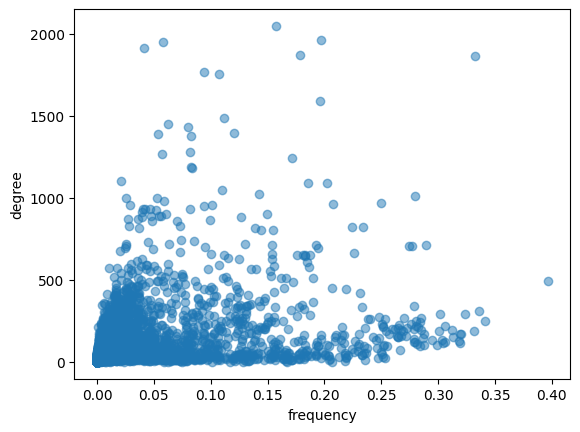

In [216]:
graph_code.plot_degree_vs_freq(G, freqs_11b)

### Visualising the largest component

In [364]:
graph_code.plot_connected_component(G, node=7)

In [369]:
community = list(next_level_communities[1])
graph_code.plot_connected_component(G.subgraph(community), node=community[0])

### Education related features

In [416]:
G.edges([16124], data=True)

EdgeDataView([(16124, 215, {'weight': tensor(0.0324)}), (16124, 708, {'weight': tensor(0.1515)}), (16124, 724, {'weight': tensor(0.0873)}), (16124, 1337, {'weight': tensor(0.0876)}), (16124, 1398, {'weight': tensor(0.0557)}), (16124, 2021, {'weight': tensor(0.0175)}), (16124, 2032, {'weight': tensor(0.1781)}), (16124, 2246, {'weight': tensor(0.0250)}), (16124, 2264, {'weight': tensor(0.0311)}), (16124, 2505, {'weight': tensor(0.3547)}), (16124, 3014, {'weight': tensor(0.0436)}), (16124, 3186, {'weight': tensor(0.3766)}), (16124, 3234, {'weight': tensor(0.0887)}), (16124, 3362, {'weight': tensor(0.0367)}), (16124, 4615, {'weight': tensor(0.1153)}), (16124, 4685, {'weight': tensor(0.0305)}), (16124, 4864, {'weight': tensor(0.1506)}), (16124, 5590, {'weight': tensor(0.0413)}), (16124, 5841, {'weight': tensor(0.0333)}), (16124, 7120, {'weight': tensor(0.3306)}), (16124, 7147, {'weight': tensor(0.1058)}), (16124, 7505, {'weight': tensor(0.0482)}), (16124, 7660, {'weight': tensor(0.0139)}), 

In [417]:
get_logit_effect(16124)

,token,logit
37593,student,6.273560
40298,Students,6.244616
5805,·student,5.908807
23493,·colleges,5.900849
3371,·students,5.880671
34937,Student,5.871859
21041,·Students,5.834585
14540,·faculty,5.720473
44922,·campuses,5.630001
41885,·Colleg,5.500592


In [418]:
get_logit_effect(2505)

,token,logit
44566,·instructors,4.593731
38823,·learners,4.490813
29418,·instructor,4.141757
28692,·Course,4.091094
9299,·teaching,4.062694
13151,·courses,4.058819
41734,Learning,4.020531
16053,·lesson,4.008470
43482,·Teaching,3.991365
9537,·teach,3.967116


### Investigating paths

In [387]:
print(f'Path between pronoun feature and male gender feature: {nx.shortest_path(G, source=7, target=12711, weight=None)}')
print(f'Path between pronoun feature and female gender feature: {nx.shortest_path(G, source=7, target=10391, weight=None)}')
print('=================')
print(f'Weighted Path between pronoun feature and male gender feature: {nx.shortest_path(G, source=7, target=12711, weight=custom_weight)}')
print(f'Weighted Path between pronoun feature and female gender feature: {nx.shortest_path(G, source=7, target=10391, weight=custom_weight)}')

Path between pronoun feature and male gender feature: [7, 13651, 1061, 12711]
Path between pronoun feature and female gender feature: [7, 882, 10391]
Weighted Path between pronoun feature and male gender feature: [7, 14506, 14163, 12711]
Weighted Path between pronoun feature and female gender feature: [7, 13492, 10391]


In [408]:
print(f'Path between bio feature and male gender feature: {nx.shortest_path(G, source=5156, target=12711, weight=None)}')
print(f'Path between bio feature and female gender feature: {nx.shortest_path(G, source=5156, target=10391, weight=None)}')
print('=================')
print(f'Weighted Path between bio feature and male gender feature: {nx.shortest_path(G, source=5156, target=12711, weight=custom_weight)}')
print(f'Weighted Path between bio feature and female gender feature: {nx.shortest_path(G, source=5156, target=10391, weight=custom_weight)}')

Path between bio feature and male gender feature: [5156, 1061, 12711]
Path between bio feature and female gender feature: [5156, 665, 10391]
Weighted Path between bio feature and male gender feature: [5156, 9484, 4830, 12711]
Weighted Path between bio feature and female gender feature: [5156, 6463, 10391]
